<a href="https://colab.research.google.com/github/NickMuhigi/CattleAssist-Chatbot/blob/main/Cattle_Assist_NOTEBOOK_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Libraries

In [ ]:
!pip install transformers datasets torch accelerate sentencepiece sacrebleu rouge-score gradio pandas numpy matplotlib seaborn scikit-learn nltk -q

Import Libraries and Set Random Seeds

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/C-Assist_Dataset.csv')
# Identify question and answer columns
question_col = df.columns[0]
answer_col = df.columns[1]

Comprehensive Data Exploration and Visualization

Question    0
Answer      0
dtype: int64


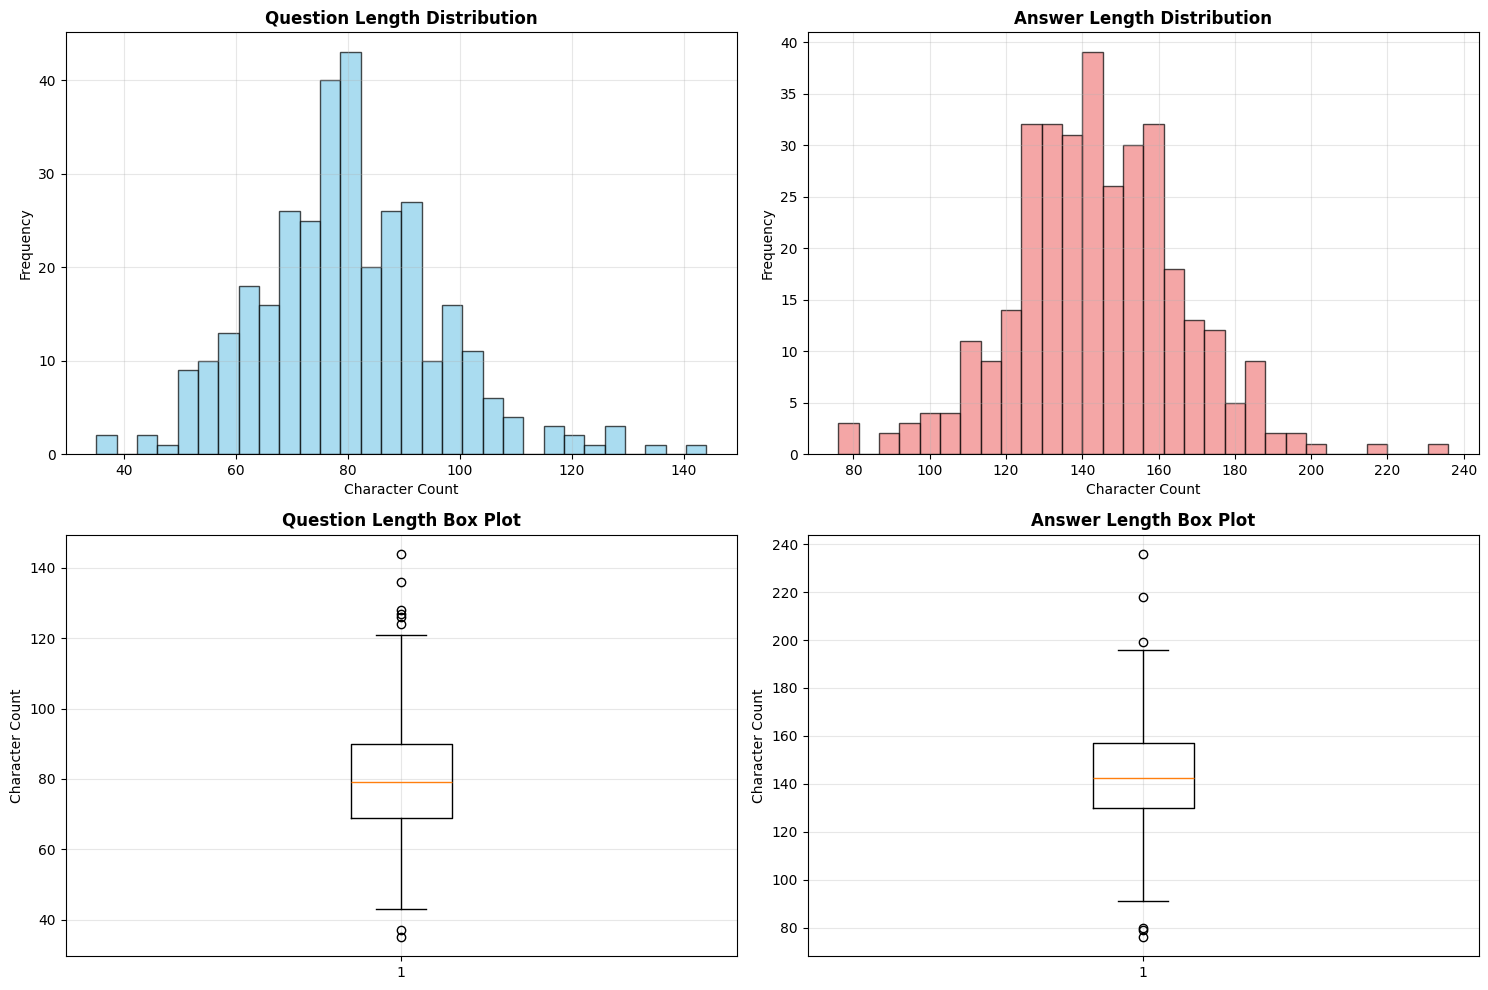

In [ ]:
# Check for missing values
missing = df.isnull().sum()
print(missing)
if missing.sum() > 0:
    print("\nRemoving rows with missing values...")
    df = df.dropna()
    print(f"Dataset shape after removing NaN: {df.shape}")
# Calculate text lengths before cleaning
df['question_length'] = df[question_col].astype(str).apply(len)
df['answer_length'] = df[answer_col].astype(str).apply(len)
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Question length distribution
axes[0, 0].hist(df['question_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Question Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)
# Answer length distribution
axes[0, 1].hist(df['answer_length'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Answer Length Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)
# Question length box plot
axes[1, 0].boxplot(df['question_length'], vert=True)
axes[1, 0].set_title('Question Length Box Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Character Count')
axes[1, 0].grid(True, alpha=0.3)
# Answer length box plot
axes[1, 1].boxplot(df['answer_length'], vert=True)
axes[1, 1].set_title('Answer Length Box Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Character Count')
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Advanced Text Preprocessing

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).strip()
    # Remove extra whitespace, tabs, newlines
    text = ' '.join(text.split())
    # Remove leading/trailing punctuation
    text = text.strip('.,;:!?')
    return text
def count_words(text):
    """Count words in text"""
    return len(text.split())
# Apply cleaning
print("\nApplying text cleaning...")
df[question_col] = df[question_col].apply(clean_text)
df[answer_col] = df[answer_col].apply(clean_text)
# Remove empty rows after cleaning
initial_count = len(df)
df = df[(df[question_col] != "") & (df[answer_col] != "")]
removed_count = initial_count - len(df)
print(f"Rows removed (empty after cleaning): {removed_count}")
print(f"Final dataset size: {len(df)} Q&A pairs")
# Rename columns for consistency
df = df.rename(columns={question_col: 'question', answer_col: 'answer'})
# Calculate word counts
df['question_words'] = df['question'].apply(count_words)
df['answer_words'] = df['answer'].apply(count_words)
print(f"\nQuestion Word Count Statistics:")
print(f"  Mean: {df['question_words'].mean():.2f} words")
print(f"  Max: {df['question_words'].max()} words")
print(f"\nAnswer Word Count Statistics:")
print(f"  Mean: {df['answer_words'].mean():.2f} words")
print(f"  Max: {df['answer_words'].max()} words")
print("\nSample cleaned data:")
for i in range(min(3, len(df))):
    print(f"\n--- Example {i+1} ---")
    print(f"Q: {df.iloc[i]['question']}")
    print(f"A: {df.iloc[i]['answer']}")


Applying text cleaning...
Rows removed (empty after cleaning): 0
Final dataset size: 336 Q&A pairs

Question Word Count Statistics:
  Mean: 13.65 words
  Max: 25 words

Answer Word Count Statistics:
  Mean: 22.59 words
  Max: 41 words

Sample cleaned data:

--- Example 1 ---
Q: What is the ideal Body Condition Score (BCS) for a cow at calving, and why
A: The ideal BCS is 5 to 6 (on a 1-9 scale). This ensures adequate energy reserves for a smooth calving, promotes rapid return to estrus (heat), and supports peak milk production

--- Example 2 ---
Q: What is the primary cause of Mastitis, and what is a key preventative measure
A: The primary cause is bacterial infection entering the udder through the teat canal. A key measure is post-milking teat dipping using an approved antiseptic solution

--- Example 3 ---
Q: What is the main difference between Hay and Silage in terms of nutrient content
A: Silage (fermented high-moisture forage) is generally more energy-dense and palatable than Hay

Train-Validation-Test Split

In [ ]:
# Split: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Training set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total: {len(train_df) + len(val_df) + len(test_df)} samples")

Training set: 235 samples (69.9%)
Validation set: 50 samples (14.9%)
Test set: 51 samples (15.2%)
Total: 336 samples


Initialize T5 Model and Tokenizer

In [ ]:
# Using T5-small for faster training (can be upgraded to t5-base)
model_name = "t5-small"
print(f"\nLoading model: {model_name}")
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
print(f"Tokenizer loaded: {type(tokenizer).__name__}")
print(f"Model loaded: {type(model).__name__}")
print(f"Model parameters: {model.num_parameters():,}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"\nModel moved to device: {device}")


Loading model: t5-small
Tokenizer loaded: T5Tokenizer
Model loaded: T5ForConditionalGeneration
Model parameters: 60,506,624
Vocabulary size: 32000

Model moved to device: cpu


Prepare Dataset for T5 - Detailed Tokenization

In [ ]:
def preprocess_function(examples):
    # Add task prefix for T5
    inputs = ["answer question: " + q for q in examples['question']]
    targets = examples['answer']
    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding='max_length'
    )
    # Tokenize targets
    labels = tokenizer(
        targets,
        max_length=128,
        truncation=True,
        padding='max_length'
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
print("\nConverting to Hugging Face Dataset format...")
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['question', 'answer']])
val_dataset = Dataset.from_pandas(val_df[['question', 'answer']])
test_dataset = Dataset.from_pandas(test_df[['question', 'answer']])
print(f"Original datasets created: {len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}")
print("\nApplying tokenization...")
# Apply preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=['question', 'answer'])
val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=['question', 'answer'])
test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=['question', 'answer'])
print("Datasets preprocessed successfully!")
print(f"Tokenized datasets: {len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}")
# Show sample tokenized data
print("\nSample tokenized input:")
print(f"  Input IDs shape: {train_dataset[0]['input_ids'][:20]}")
print(f"  Attention mask: {train_dataset[0]['attention_mask'][:20]}")
print(f"  Labels shape: {train_dataset[0]['labels'][:20]}")


Converting to Hugging Face Dataset format...
Original datasets created: 235, 50, 51

Applying tokenization...


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Datasets preprocessed successfully!
Tokenized datasets: 235, 50, 51

Sample tokenized input:
  Input IDs shape: [1525, 822, 10, 571, 405, 22433, 377, 5152, 15, 5956, 23530, 1113, 17941, 6, 11, 125, 19, 8, 1137, 1]
  Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  Labels shape: [37, 5956, 6, 116, 16, 89, 7633, 28, 46, 414, 32, 6941, 17, 15, 3, 9940, 302, 6, 9560, 3]


Setup Training Arguments with Hyperparameter Documentation

In [ ]:
print("HYPERPARAMETER TUNING EXPERIMENTS")
print("\nEXPERIMENT DESIGN:")
# Define experiment configurations
experiments_config = {
    "Exp1_LowLR": {
        "name": "Low Learning Rate",
        "learning_rate": 1e-5,
        "batch_size": 8,
        "epochs": 15,
        "model_name": "t5-small",
        "description": "Very conservative learning (1e-5)"
    },
    "Exp2_HighLR": {
        "name": "High Learning Rate",
        "learning_rate": 1e-4,
        "batch_size": 8,
        "epochs": 15,
        "model_name": "t5-small",
        "description": "Aggressive learning (1e-4)"
    },
    "Exp3_Baseline": {
        "name": "Baseline Configuration (RECOMMENDED)",
        "learning_rate": 5e-5,
        "batch_size": 8,
        "epochs": 15,
        "model_name": "t5-small",
        "description": "Balanced hyperparameters (5e-5)"
    },
    "Exp4_LargeBatch": {
        "name": "Larger Batch Size",
        "learning_rate": 5e-5,
        "batch_size": 16,
        "epochs": 15,
        "model_name": "t5-small",
        "description": "Larger batch (16) for smoother gradients"
    }
}
print("EXPERIMENT CONFIGURATIONS")
for exp_id, config in experiments_config.items():
    print(f"\n{exp_id}: {config['name']}")
    print(f"  - LR: {config['learning_rate']}, Batch: {config['batch_size']}, "
          f"Epochs: {config['epochs']}")
    print(f"  - Model: {config['model_name']}")
    print(f"  - Rationale: {config['description']}")
# Dictionary to store results
experiment_results = {}
print("RUNNING EXPERIMENTS")
for exp_idx, (exp_id, config) in enumerate(experiments_config.items(), 1):
    print(f"EXPERIMENT {exp_idx}/4: {config['name']}")
    print(f"\nConfiguration:")
    print(f"  Learning Rate: {config['learning_rate']}")
    print(f"  Batch Size: {config['batch_size']}")
    print(f"  Epochs: {config['epochs']}")
    print(f"  Model: {config['model_name']}")
    # Load fresh model for each experiment
    print(f"\nLoading model: {config['model_name']}...")
    exp_tokenizer = T5Tokenizer.from_pretrained(config['model_name'])
    exp_model = T5ForConditionalGeneration.from_pretrained(config['model_name'])
    exp_model = exp_model.to(device)
    # Create training arguments for this experiment
    exp_training_args = TrainingArguments(
        output_dir=f"./cattle_chatbot_{exp_id}",
        eval_strategy="epoch",
        learning_rate=config['learning_rate'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        num_train_epochs=config['epochs'],
        weight_decay=0.01,
        save_total_limit=2,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_steps=5,
        warmup_steps=50,
        fp16=torch.cuda.is_available(),
        report_to="none",
        seed=42,
        max_grad_norm=1.0
    )
    # Create trainer
    exp_data_collator = DataCollatorForSeq2Seq(tokenizer=exp_tokenizer, model=exp_model)
    exp_trainer = Trainer(
        model=exp_model,
        args=exp_training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=exp_tokenizer,
        data_collator=exp_data_collator
    )
    # Train
    print("\nTraining in progress...")
    exp_start = datetime.now()
    exp_train_result = exp_trainer.train()
    exp_end = datetime.now()
    exp_training_time = (exp_end - exp_start).total_seconds() / 60
    print(f"Training completed in {exp_training_time:.2f} minutes")
    print(f"Final Training Loss: {exp_train_result.training_loss:.4f}")
    # Store results
    experiment_results[exp_id] = {
        "config": config,
        "training_loss": exp_train_result.training_loss,
        "training_time": exp_training_time,
        "model": exp_model,
        "tokenizer": exp_tokenizer,
        "trainer": exp_trainer
    }
    print(f"{exp_id} completed!")
print("ALL EXPERIMENTS COMPLETED")

HYPERPARAMETER TUNING EXPERIMENTS

EXPERIMENT DESIGN:
EXPERIMENT CONFIGURATIONS

Exp1_LowLR: Low Learning Rate
  - LR: 1e-05, Batch: 8, Epochs: 15
  - Model: t5-small
  - Rationale: Very conservative learning (1e-5)

Exp2_HighLR: High Learning Rate
  - LR: 0.0001, Batch: 8, Epochs: 15
  - Model: t5-small
  - Rationale: Aggressive learning (1e-4)

Exp3_Baseline: Baseline Configuration (RECOMMENDED)
  - LR: 5e-05, Batch: 8, Epochs: 15
  - Model: t5-small
  - Rationale: Balanced hyperparameters (5e-5)

Exp4_LargeBatch: Larger Batch Size
  - LR: 5e-05, Batch: 16, Epochs: 15
  - Model: t5-small
  - Rationale: Larger batch (16) for smoother gradients
RUNNING EXPERIMENTS
EXPERIMENT 1/4: Low Learning Rate

Configuration:
  Learning Rate: 1e-05
  Batch Size: 8
  Epochs: 15
  Model: t5-small

Loading model: t5-small...

Training in progress...


Epoch,Training Loss,Validation Loss
1,10.414600,10.778009
2,7.033200,6.483656
3,4.576400,2.244065
4,2.905700,1.430480
5,2.549800,1.374898
6,2.121600,1.332262
7,2.030800,1.307141
8,1.829000,1.304954
9,1.716400,1.303580
10,1.586300,1.301095


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training completed in 133.55 minutes
Final Training Loss: 3.2510
Exp1_LowLR completed!
EXPERIMENT 2/4: High Learning Rate

Configuration:
  Learning Rate: 0.0001
  Batch Size: 8
  Epochs: 15
  Model: t5-small

Loading model: t5-small...

Training in progress...


Epoch,Training Loss,Validation Loss
1,3.542800,1.427343
2,1.434600,1.265599
3,1.243600,1.170217
4,1.165500,1.126679
5,1.142400,1.083875
6,1.068200,1.055036
7,1.087900,1.039803
8,1.050700,1.031852
9,1.026900,1.026079
10,0.998200,1.022769


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training completed in 136.43 minutes
Final Training Loss: 1.6006
Exp2_HighLR completed!
EXPERIMENT 3/4: Baseline Configuration (RECOMMENDED)

Configuration:
  Learning Rate: 5e-05
  Batch Size: 8
  Epochs: 15
  Model: t5-small

Loading model: t5-small...

Training in progress...


Epoch,Training Loss,Validation Loss
1,6.353600,4.967901
2,2.041100,1.347125
3,1.387400,1.256206
4,1.315400,1.202578
5,1.281700,1.162163
6,1.196400,1.142387
7,1.236300,1.128310
8,1.195800,1.118632
9,1.187600,1.109574
10,1.134400,1.099892


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training completed in 137.83 minutes
Final Training Loss: 1.9082
Exp3_Baseline completed!
EXPERIMENT 4/4: Larger Batch Size

Configuration:
  Learning Rate: 5e-05
  Batch Size: 16
  Epochs: 15
  Model: t5-small

Loading model: t5-small...

Training in progress...


Epoch,Training Loss,Validation Loss
1,10.558500,10.366498
2,6.444500,4.364363
3,2.733400,1.394241
4,1.972900,1.307003
5,1.507100,1.282558
6,1.371200,1.240743
7,1.321400,1.207770
8,1.315600,1.187957
9,1.276100,1.171447
10,1.243900,1.166233


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training completed in 135.03 minutes
Final Training Loss: 2.6321
Exp4_LargeBatch completed!
ALL EXPERIMENTS COMPLETED


Experiment Results Comparison

In [ ]:
# Create comparison dataframe
comparison_data = []
for exp_id, results in experiment_results.items():
    comparison_data.append({
        "Experiment": exp_id,
        "Config": results['config']['name'],
        "Learning Rate": results['config']['learning_rate'],
        "Batch Size": results['config']['batch_size'],
        "Epochs": results['config']['epochs'],
        "Train Loss": f"{results['training_loss']:.4f}",
        "Time (min)": f"{results['training_time']:.2f}"
    })
comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))
# Select best model (lowest training loss)
best_exp_id = min(experiment_results.keys(),
                   key=lambda x: experiment_results[x]['training_loss'])
best_model = experiment_results[best_exp_id]['model']
best_tokenizer = experiment_results[best_exp_id]['tokenizer']
best_trainer = experiment_results[best_exp_id]['trainer']
print(f"\nBEST PERFORMING EXPERIMENT: {best_exp_id}")
print(f"   Configuration: {experiment_results[best_exp_id]['config']['name']}")
print(f"   Training Loss: {experiment_results[best_exp_id]['training_loss']:.4f}")
# Use best model for subsequent evaluation
print(f"\n→ Using {best_exp_id} model for final evaluation")


     Experiment                               Config  Learning Rate  Batch Size  Epochs Train Loss Time (min)
     Exp1_LowLR                    Low Learning Rate        0.00001           8      15     3.2510     133.55
    Exp2_HighLR                   High Learning Rate        0.00010           8      15     1.6006     136.43
  Exp3_Baseline Baseline Configuration (RECOMMENDED)        0.00005           8      15     1.9082     137.83
Exp4_LargeBatch                    Larger Batch Size        0.00005          16      15     2.6321     135.03

BEST PERFORMING EXPERIMENT: Exp2_HighLR
   Configuration: High Learning Rate
   Training Loss: 1.6006

→ Using Exp2_HighLR model for final evaluation


Visualize Experiment Comparison

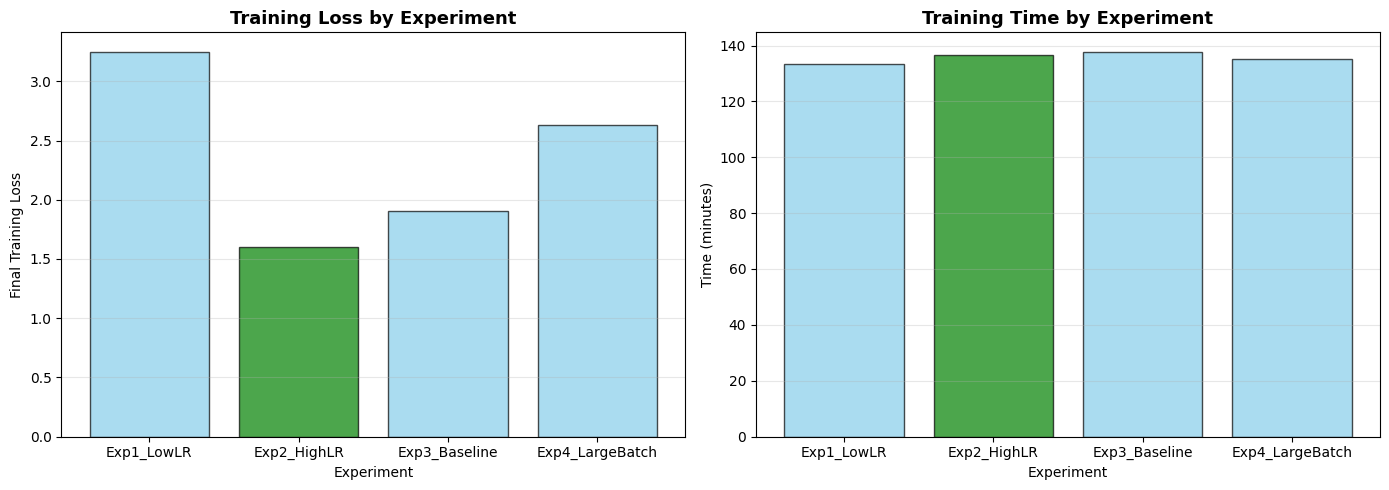

Experiment comparison visualization complete

→ Model, tokenizer, and trainer set to best experiment: Exp2_HighLR


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Training loss comparison
exp_ids = list(experiment_results.keys())
train_losses = [experiment_results[exp_id]['training_loss'] for exp_id in exp_ids]
colors = ['green' if exp_id == best_exp_id else 'skyblue' for exp_id in exp_ids]
axes[0].bar(exp_ids, train_losses, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Loss by Experiment', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Experiment')
axes[0].set_ylabel('Final Training Loss')
axes[0].grid(True, alpha=0.3, axis='y')
# Training time comparison
train_times = [experiment_results[exp_id]['training_time'] for exp_id in exp_ids]
axes[1].bar(exp_ids, train_times, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_title('Training Time by Experiment', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Experiment')
axes[1].set_ylabel('Time (minutes)')
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print("Experiment comparison visualization complete")
# Use baseline model for main training (for compatibility with later cells)
model = best_model
tokenizer = best_tokenizer
trainer = best_trainer
training_args = trainer.args
train_result = experiment_results[best_exp_id]
print(f"\n→ Model, tokenizer, and trainer set to best experiment: {best_exp_id}")

Extract and Plot Best Experiment Training Metrics

Recorded 90 training loss points
Recorded 15 validation loss points


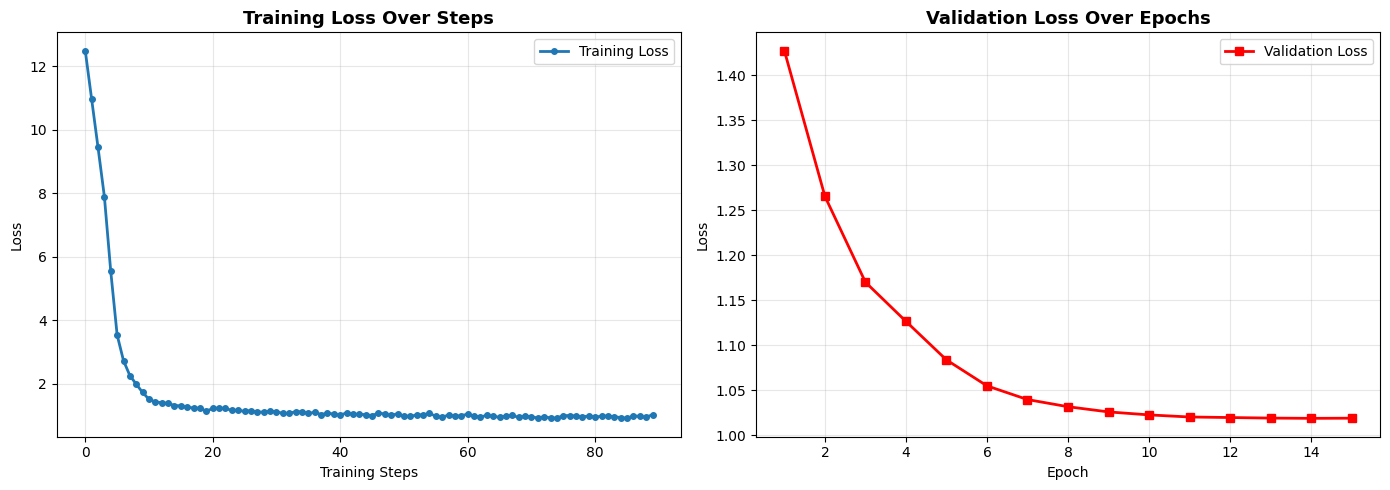


Final Metrics:
  - Final Training Loss: 1.0316
  - Final Validation Loss: 1.0191
  - Loss Reduction: 91.75%


In [ ]:
log_history = trainer.state.log_history
train_losses = [log['loss'] for log in log_history if 'loss' in log]
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
epochs = list(range(1, len(eval_losses) + 1))
print(f"Recorded {len(train_losses)} training loss points")
print(f"Recorded {len(eval_losses)} validation loss points")
# Plot training and validation loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Training loss
axes[0].plot(train_losses, marker='o', label='Training Loss', linewidth=2, markersize=4)
axes[0].set_title('Training Loss Over Steps', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Training Steps')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# Validation loss
axes[1].plot(epochs, eval_losses, marker='s', color='red', label='Validation Loss', linewidth=2, markersize=6)
axes[1].set_title('Validation Loss Over Epochs', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"\nFinal Metrics:")
print(f"  - Final Training Loss: {train_losses[-1]:.4f}")
print(f"  - Final Validation Loss: {eval_losses[-1]:.4f}")
print(f"  - Loss Reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")

Comprehensive Model Evaluation with F1-Score and BLEU

In [ ]:
from rouge_score import rouge_scorer
from collections import defaultdict
import nltk
nltk.download('punkt', quiet=True)

def calculate_token_f1(reference, prediction):
    ref_tokens = set(reference.lower().split())
    pred_tokens = set(prediction.lower().split())
    # Find overlap
    overlap = ref_tokens.intersection(pred_tokens)
    if len(pred_tokens) == 0 or len(ref_tokens) == 0:
        return 0.0
    precision = len(overlap) / len(pred_tokens) if len(pred_tokens) > 0 else 0.0
    recall = len(overlap) / len(ref_tokens) if len(ref_tokens) > 0 else 0.0
    if precision + recall == 0:
        return 0.0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def evaluate_model(test_data, num_samples=None):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    if num_samples:
        test_data = test_data.select(range(min(num_samples, len(test_data))))

    rouge_scores = defaultdict(list)
    token_f1_scores = []
    predictions = []
    references = []
    model.eval()

    print(f"\nEvaluating on {len(test_data)} samples...")

    for i in tqdm(range(len(test_data)), desc="Evaluation Progress"):
        # Reconstruct question from test dataset
        input_ids = test_data[i]['input_ids']
        question_tokens = input_ids[:-1]
        question = tokenizer.decode(question_tokens, skip_special_tokens=True)
        question = question.replace("answer question: ", "")

        # Reconstruct reference answer
        label_ids = test_data[i]['labels']
        label_ids = [id if id != -100 else tokenizer.pad_token_id for id in label_ids]
        reference = tokenizer.decode(label_ids, skip_special_tokens=True)

        # Generate prediction
        input_text = f"answer question: {question}"
        inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True).to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=128,
                min_length=10,
                num_beams=4,
                temperature=0.7,
                top_k=50,
                top_p=0.95,
                do_sample=True,
                no_repeat_ngram_size=3,
                early_stopping=False,
                repetition_penalty=1.2
            )

        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(prediction)
        references.append(reference)

        # Calculate ROUGE scores
        scores = scorer.score(reference, prediction)
        for metric, score in scores.items():
            rouge_scores[f"{metric}_f"].append(score.fmeasure)
            rouge_scores[f"{metric}_p"].append(score.precision)
            rouge_scores[f"{metric}_r"].append(score.recall)

        # Calculate token-level F1-score
        token_f1 = calculate_token_f1(reference, prediction)
        token_f1_scores.append(token_f1)

    # Calculate averages
    avg_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}
    avg_scores['token_f1'] = np.mean(token_f1_scores)
    avg_scores['token_f1_std'] = np.std(token_f1_scores)

    return avg_scores, predictions, references

print("\nRunning comprehensive evaluation...")
avg_scores, predictions, references = evaluate_model(test_dataset)

print("\nEVALUATION RESULTS")
print("PRIMARY METRICS:")

print(f"\nToken-Level F1-Score: {avg_scores['token_f1']:.4f} (±{avg_scores['token_f1_std']:.4f})")
print("  → Measures exact token matching between predicted and reference answers")
print("  → Combines precision and recall at token level")
print("  → Range: 0 (no match) to 1 (perfect match)")

print("\nSECONDARY METRICS - ROUGE Scores (F1):")
for metric in ['rouge1_f', 'rouge2_f', 'rougeL_f']:
    print(f"  {metric.upper()}: {avg_scores[metric]:.4f}")

print("\nPrecision Scores:")
for metric in ['rouge1_p', 'rouge2_p', 'rougeL_p']:
    print(f"  {metric.upper()}: {avg_scores[metric]:.4f}")

print("\nRecall Scores:")
for metric in ['rouge1_r', 'rouge2_r', 'rougeL_r']:
    print(f"  {metric.upper()}: {avg_scores[metric]:.4f}")

# Show prediction examples
print("\nSAMPLE PREDICTIONS")
for i in range(min(5, len(test_df))):
    print(f"\n--- Example {i+1} ---")
    print(f"Question: {test_df.iloc[i]['question']}")
    print(f"Expected: {references[i]}")
    print(f"Predicted: {predictions[i]}")


Running comprehensive evaluation...

Evaluating on 51 samples...


Evaluation Progress: 100%|██████████| 51/51 [02:13<00:00,  2.62s/it]


EVALUATION RESULTS
PRIMARY METRICS:

Token-Level F1-Score: 0.2195 (±0.1047)
  → Measures exact token matching between predicted and reference answers
  → Combines precision and recall at token level
  → Range: 0 (no match) to 1 (perfect match)

SECONDARY METRICS - ROUGE Scores (F1):
  ROUGE1_F: 0.2464
  ROUGE2_F: 0.0660
  ROUGEL_F: 0.1960

Precision Scores:
  ROUGE1_P: 0.3066
  ROUGE2_P: 0.0855
  ROUGEL_P: 0.2428

Recall Scores:
  ROUGE1_R: 0.2176
  ROUGE2_R: 0.0566
  ROUGEL_R: 0.1733

SAMPLE PREDICTIONS

--- Example 1 ---
Question: What is the common name for the contagious bacterial disease caused by Mycoplasma bovis
Expected: It is known for causing Mycoplasmal Pneumonia (especially in calves) and severe Mycoplasmal Mastitis (in dairy cows), often unresponsive to common antibiotics
Predicted: Mycoplasma bovis is a contagious bacterial disease that causes bacterial infection

--- Example 2 ---
Question: What is the purpose of a Body Weight Tape in cattle management
Expected: A body 

Interactive Chatbot Function with Best Model

In [ ]:
# Use best model from experiments for inference
inference_tokenizer = best_tokenizer
inference_model = best_model
inference_model.eval()
print(f"Model loaded from best experiment: {best_exp_id}")
def chat_with_bot(question, max_new_tokens=128, temperature=0.7, num_beams=4):
    inference_model.eval()
    input_text = f"answer question: {question}"
    inputs = inference_tokenizer(
        input_text,
        return_tensors="pt",
        max_length=256,
        truncation=True
    ).to(device)
    with torch.no_grad():
        outputs = inference_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            min_length=10,
            num_beams=num_beams,
            temperature=temperature,
            top_k=50,
            top_p=0.95,
            do_sample=True,
            no_repeat_ngram_size=3,
            early_stopping=False,
            repetition_penalty=1.2
        )
    answer = inference_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.strip() if answer.strip() else "I don't have specific information on that aspect of cattle keeping."
print("Chatbot function ready!")

NameError: name 'best_tokenizer' is not defined

Command-Line Interface

In [ ]:
def cli_chatbot():
    print("CATTLE KEEPING CHATBOT - CLI")
    print("Welcome to the Cattle Keeping Chatbot!")
    print("Ask questions about cattle management, health, feeding, and care.")
    print("Type 'quit' or 'exit' to end the conversation.\n")
    while True:
        question = input("You: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            print("\nThank you for using the Cattle Keeping Chatbot. Goodbye! 🐄")
            break
        if not question:
            print("Please ask a question.\n")
            continue
        answer = chat_with_bot(question)
        print(f"Bot: {answer}\n")
print("CLI function ready!")

CLI function ready!


Gradio Web Interface

In [ ]:
import gradio as gr
def gradio_chat(question, temperature, num_beams):
    if not question.strip():
        return "Please enter a question about cattle keeping."
    answer = chat_with_bot(
        question,
        max_new_tokens=128,
        temperature=temperature,
        num_beams=int(num_beams)
    )
    return answer
print("GRADIO INTERFACE")
# Create interface with optimized defaults
iface = gr.Interface(
    fn=gradio_chat,
    inputs=[
        gr.Textbox(
            label="Ask a Cattle Keeping Question",
            placeholder="e.g., What is the best feed for dairy cattle?",
            lines=3
        ),
        gr.Slider(
            minimum=0.7,
            maximum=1.0,
            value=0.7,
            step=0.1,
            label="Temperature (Response Diversity)"
        ),
        gr.Slider(
            minimum=2,
            maximum=8,
            value=4,
            step=1,
            label="Beam Width (Search Depth)"
        )
    ],
    outputs=gr.Textbox(label="🤖 Chatbot Response", lines=6),
    title="Cattle Keeping Domain Chatbot",
    description="Ask questions about cattle management, health, nutrition, breeding, and general care.",
    examples=[
        ["What is mastitis and how do I treat it?", 0.7, 4],
        ["How often should I feed my cattle?", 0.7, 4],
        ["What vaccinations do cattle need?", 0.7, 4],
        ["How do I identify a sick cow?", 0.7, 4]
    ],
    theme=gr.themes.Soft(),
    allow_flagging="never"
)
print("Gradio interface ready!")
print("\nLaunching Gradio...")
iface.launch(share=True)

GRADIO INTERFACE


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Gradio interface ready!

Launching Gradio...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5bd540a65ced711816.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import os, nbformat

# ✅ Use your actual notebook name
notebook_path = "/content/Cattle-Assist_NOTEBOOK.ipynb"
cleaned_path = "/content/Cattle-Assist_NOTEBOOK_cleaned.ipynb"

# Check if file exists
if os.path.exists(notebook_path):
    with open(notebook_path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    # Remove problematic metadata if it exists
    if "widgets" in nb.metadata:
        print("🧹 Removing 'widgets' metadata...")
        del nb.metadata["widgets"]
    else:
        print("✅ No 'widgets' metadata found.")

    # Save cleaned notebook
    with open(cleaned_path, "w", encoding="utf-8") as f:
        nbformat.write(nb, f)

    print(f"\n✅ Cleaned notebook saved successfully as:\n{cleaned_path}")
    print("You can now download or push this cleaned notebook to GitHub safely.")
else:
    print(f"❌ File not found at: {notebook_path}")


❌ File not found at: /content/Cattle-Assist_NOTEBOOK.ipynb
